In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model

np.random.seed(2017)

Using TensorFlow backend.


In [2]:
def data_bike_num(path_to_dataset='./bike_rnn.csv',
                           sequence_length=20,
                           ratio=1.0):

    max_values = ratio * 45949

    with open(path_to_dataset) as f:
        data = csv.reader(f, delimiter=",")
        next(data, None)  # skip the headers
        # print(len(data))
        bikes = []
        nb_of_values = 0
        for line in data:
            try:
                bikes.append(float(line[0]))
                nb_of_values += 1
            except ValueError:
                pass
            if nb_of_values >= max_values:
                break

    print ("Data loaded from csv. Formatting...")
    print(len(bikes))
    result = []
    for index in range(len(bikes) - sequence_length):
        result.append(bikes[index: index + sequence_length])
    result = np.array(result)  # shape (2049230, 50)

    result_mean = result.mean()
    result -= result_mean
    print("Shift: ", result_mean)
    print ("Data: ", result.shape)

    row = int(round(0.95 * result.shape[0]))
    train = result[:row, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1] # 2297
    y_test = result[row:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    print(X_train.shape, y_train.shape)
    return [X_train, y_train, X_test, y_test, result_mean]

In [3]:
def build_model():
    model = Sequential()
    layers = [1, 50, 100, 1]

    model.add(GRU(
        layers[1],
        input_shape=(None, layers[0]),
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['mae', 'mape'])
    print ("Compilation Time : ", time.time() - start)
    return model


In [8]:
def run_network(model=None, data=None):
    global_start_time = time.time()
    epochs = 2
    ratio = 1
    sequence_length = 20
    path_to_dataset = './bike_rnn.csv'

    if data is None:
        print ('Loading data... ')
        X_train, y_train, X_test, y_test, result_mean = data_bike_num(
            path_to_dataset, sequence_length, ratio)
    else:
        X_train, y_train, X_test, y_test = data

    print ('\nData Loaded. Compiling...\n')

    

In [10]:
[X_train, y_train, X_test, y_test, result_mean] = data_bike_num()

Data loaded from csv. Formatting...
45949
Shift:  6.997708419517081
Data:  (45929, 20)


In [11]:
X_train.shape

(43633, 19, 1)

In [12]:
y_train.shape

(43633,)

Loading data... 
Data loaded from csv. Formatting...
45949
Shift:  6.997708419517081
Data:  (45929, 20)

Data Loaded. Compiling...

Compilation Time :  0.04390978813171387
Train on 41451 samples, validate on 2182 samples
Epoch 1/2
41451/41451 [==============================] - 10s 233us/step - loss: 6.7961 - mean_absolute_error: 1.5219 - mean_absolute_percentage_error: 1281.2442 - val_loss: 2.0370 - val_mean_absolute_error: 0.9534 - val_mean_absolute_percentage_error: 698.6535
Epoch 2/2
2296/2296 [==============================] - 0s 30us/step

evaluate result: 
mse=0.445909
mae=0.437174
mape=337.011673


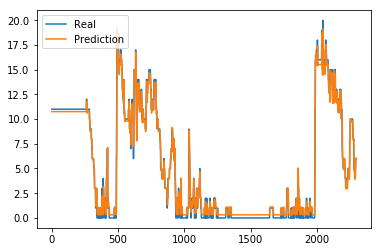

Training duration (s) :  18.028944730758667


(<keras.engine.sequential.Sequential at 0x2a5f7c48dd8>,
 array([11., 11., 11., ...,  6.,  6.,  6.]),
 array([10.754302 , 10.754302 , 10.754302 , ...,  6.066625 ,  6.0474396,
         5.978677 ], dtype=float32))

In [9]:
run_network()

In [ ]:
model = build_model()
    try:
        model.fit(
            X_train, y_train,
            batch_size=512, epochs=epochs, validation_split=0.05)
        model.save('bike.h5')
        predicted = model.predict(X_test)
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    try:
        # Evaluate
        scores = model.evaluate(X_test, y_test, batch_size=512)
        print("\nevaluate result: \nmse={:.6f}\nmae={:.6f}\nmape={:.6f}".format(scores[0], scores[1], scores[2]))

        # draw the figure
        y_test += result_mean
        predicted += result_mean

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(y_test,label="Real")
        ax.legend(loc='upper left')
        plt.plot(predicted,label="Prediction")
        plt.legend(loc='upper left')
        plt.show()

    except Exception as e:
        print (str(e))
    print ('Training duration (s) : ', time.time() - global_start_time)

    return model, y_test, predicted
